In [1]:
%matplotlib inline

import h5py
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import mode
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from hbtp import HBTReader
from src import read

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
savefig = True

In [3]:
plt.style.use("paper")

In [4]:
snap = 122
grav = "GR_b64n512"
reader = HBTReader("./data/%s/subcat/" % grav)
haloes = reader.LoadHostHalos(snap)
haloes = haloes[read.ids(grav, snap)]

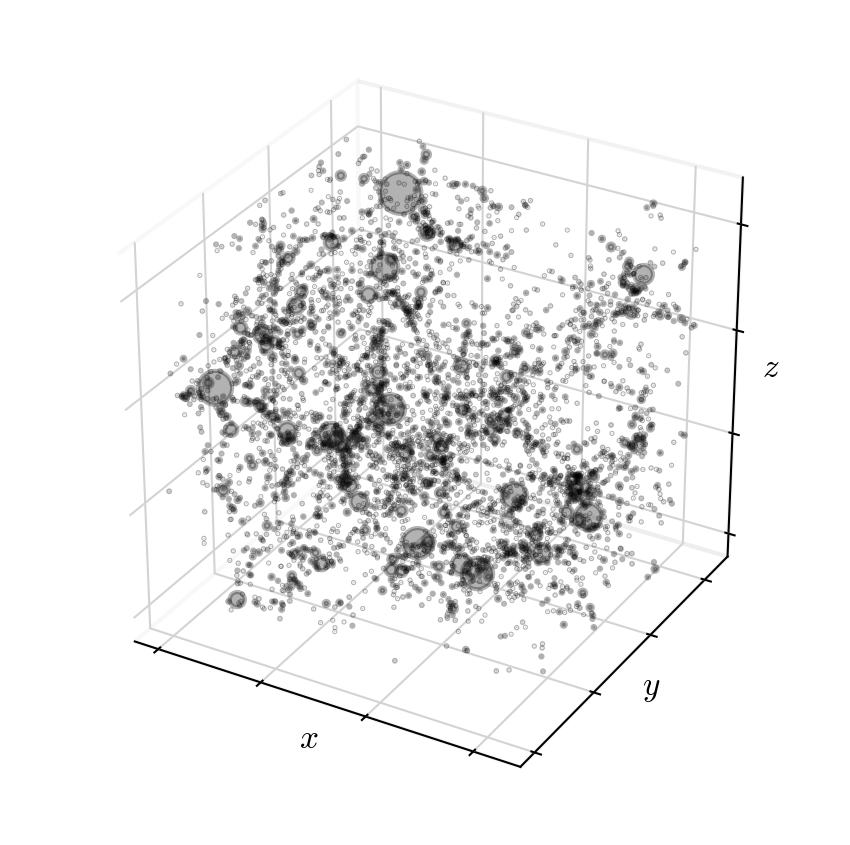

In [5]:
fig, ax = plt.subplots(1, subplot_kw={"projection": "3d"})
ax.set_xlabel(r"$x$", labelpad=-15)
ax.set_ylabel(r"$y$", labelpad=-15)
ax.set_zlabel(r"$z$", labelpad=-15)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.scatter(
    *haloes["CenterComoving"].T,
    s=100 * (haloes["M200Crit"] / haloes["M200Crit"].max()),
    c="k",
    alpha=0.3,
)

## Implementation of Haas 2011 environment definition

In [6]:
def nearest_neighbour(halo, haloes, f=1.0, N=0):
    haloes_filtered = haloes[
        (haloes["HaloId"] != halo["HaloId"])
        & (haloes["M200Crit"] >= 1.0 * halo["M200Crit"])
    ]

    if len(haloes_filtered) < 1:
        d = np.inf
    else:
        ds = np.linalg.norm(
            haloes_filtered["CenterComoving"] - halo["CenterComoving"], axis=1
        )
        idx = ds.argsort()[N]
        d = ds[idx] / haloes_filtered[idx]["R200CritComoving"]

    return d

## Other metrics (see Shi+2017)

Not implemented.

In [7]:
def spherical_overdensity(halo, r=5):
    """(Over)density within radius ``r`` of halo center.
    """
    return 0.0


def shell_overdensity(halo, r_min=1, r=5):
    """(Over)density within shell between ``r_min`` and ``r``.
    """
    return 0.0


def experienced_potential(halo):
    """Experienced gravity for a halo.
    """
    c = halo["NFW_c"]
    r_s = nfw.r_s(c)
    delta_c = nfw.delta_c(c)

    rs = np.linspace(-2.0, 0.0, 100)
    phi = [phi(r) for r in rs]

    phi_star = phi + 4 * np.pi * G * delta_c * cosmology.rho_crit(
        halo["snap"]
    ) * np.div((r_s * r_s * r_s), rs) * np.log(1.0 + rs / r_s)

    return np.mean(phi_star)

In [8]:
dnf = np.log10([nearest_neighbour(halo, haloes) for halo in tqdm(haloes)])

100%|██████████| 4252/4252 [00:01<00:00, 2744.00it/s]


In [9]:
def plot3d(xs, ys, zs, ss, cs):
    ix = ~np.isinf(cs)
    xs, ys, zs, ss, cs = xs[ix], ys[ix], zs[ix], ss[ix], cs[ix]

    scalarMap = matplotlib.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
    )
    scalarMap.set_array(cs)
    fig, ax = plt.subplots(1, subplot_kw={"projection": "3d"})
    ax.set_xlabel(r"$x$", labelpad=-15)
    ax.set_ylabel(r"$y$", labelpad=-15)
    ax.set_zlabel(r"$z$", labelpad=-15)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    fig.colorbar(scalarMap).ax.set_ylabel(
        r"$\log_{10}\left(D_{N,f}\right)$", rotation=90, labelpad=10
    )
    ax.scatter(xs, ys, zs, s=100 * (ss / ss.max()), c=scalarMap.to_rgba(cs))

    return fig, ax

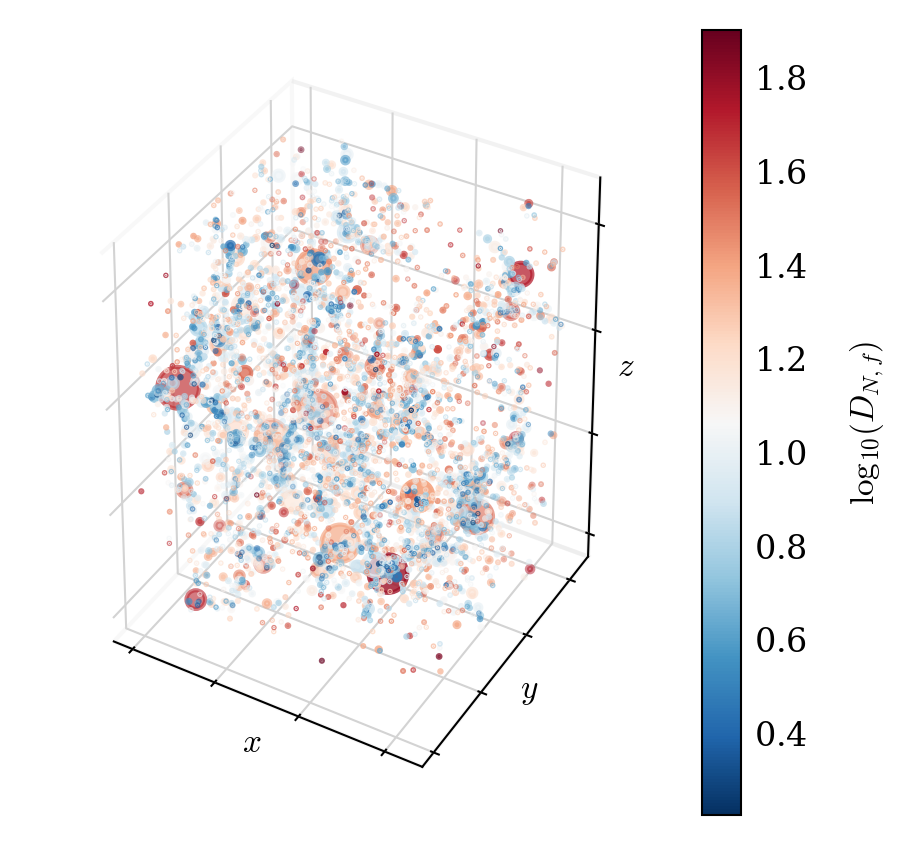

In [10]:
fig, ax = plot3d(*haloes["CenterComoving"].T, ss=haloes["M200Crit"], cs=dnf)

if savefig:
    fig.savefig("./plots/3d_%s_%03d.pdf" % (grav, snap))

### Bin splitting

Each log10 mass bin has D_Nf calculated, and is split into two sub-populations: below 25% and above 75%.

In [11]:
d = pd.DataFrame({"m": np.log10(1e10 * haloes["M200Crit"]), "d": dnf})

In [12]:
edges = 20
bin = 3

In [13]:
counts, edges = np.histogram(d["m"], edges)
centres = 0.5 * (edges[1:] + edges[:-1])

d["bin"] = np.digitize(d["m"], edges, right=True)

In [14]:
d = d[~np.isinf(d["d"])]

In [15]:
dnf_qs = d.groupby("bin").quantile([0.25, 0.75])["d"]
dnf_qs

bin      
0    0.25    1.015151
     0.75    1.255720
1    0.25    0.798387
     0.75    1.253601
2    0.25    0.791207
     0.75    1.257593
3    0.25    0.806330
     0.75    1.257763
4    0.25    0.791298
     0.75    1.266068
5    0.25    0.828005
     0.75    1.252923
6    0.25    0.842766
     0.75    1.210867
7    0.25    0.890160
     0.75    1.285143
8    0.25    0.803537
     0.75    1.249098
9    0.25    0.788611
     0.75    1.256717
10   0.25    0.917316
     0.75    1.261985
11   0.25    0.922022
     0.75    1.258703
12   0.25    0.786898
     0.75    1.215480
13   0.25    0.990988
     0.75    1.331365
14   0.25    0.872802
     0.75    1.442015
15   0.25    0.915236
     0.75    1.373488
16   0.25    1.104826
     0.75    1.263473
17   0.25    1.180427
     0.75    1.180427
18   0.25    1.407304
     0.75    1.478322
19   0.25    1.481881
     0.75    1.690189
Name: d, dtype: float64

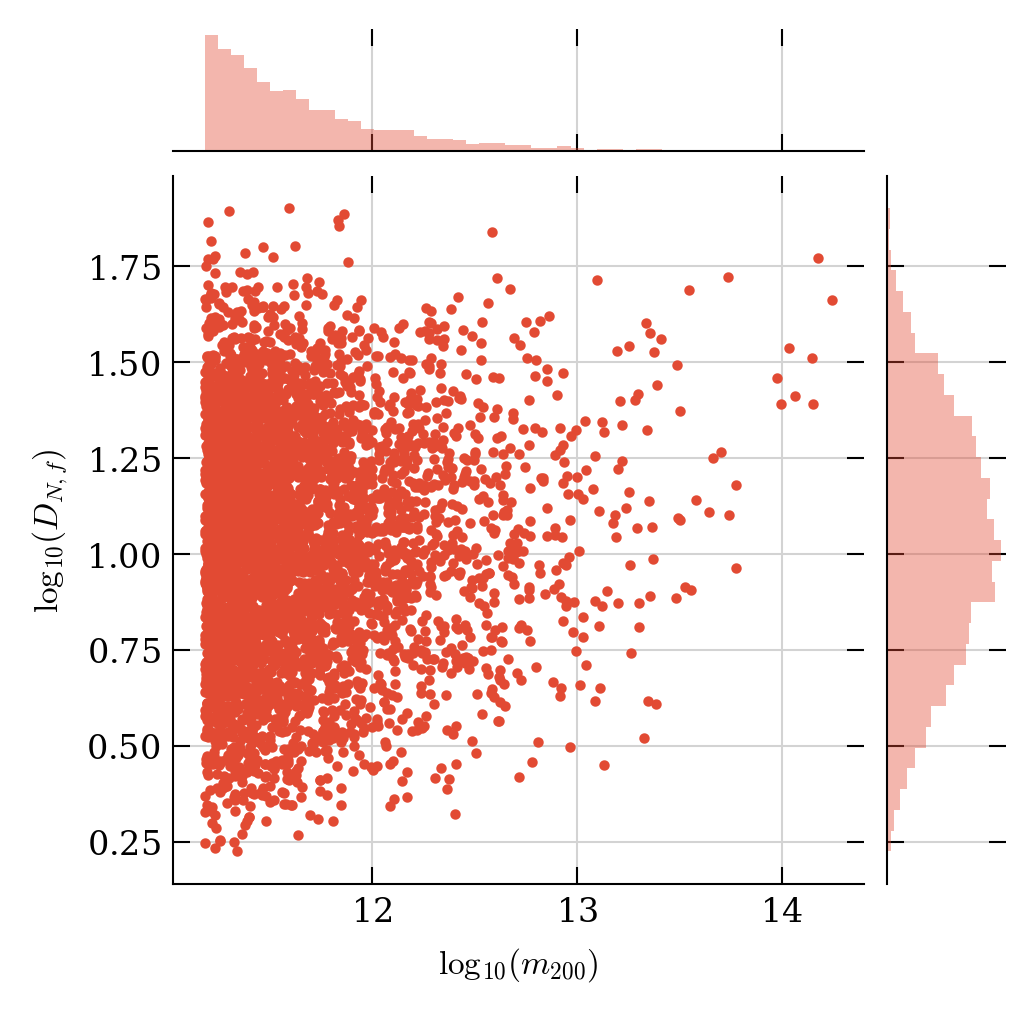

In [16]:
p = sns.jointplot(x="m", y="d", data=d, marker=".", stat_func=None, height=3.4)

p.set_axis_labels(r"$\log_{10}(m_{200})$", r"$\log_{10}(D_{N,f})$")

if savefig:
    p.savefig("./plots/dnf_%s_%03d.pdf" % (grav, snap))

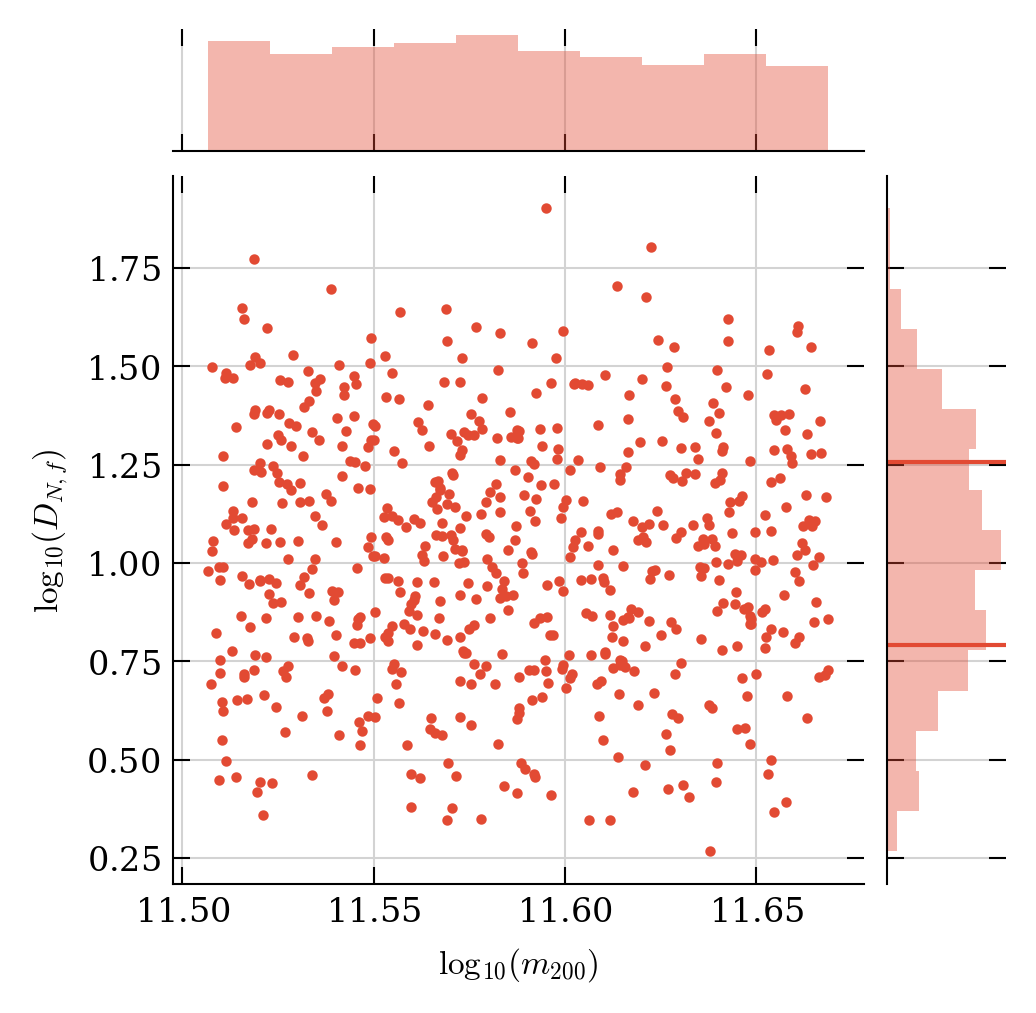

In [17]:
p = sns.jointplot(
    x="m", y="d", data=d[d["bin"] == bin], marker=".", stat_func=None, height=3.4
)

plt.axhline(dnf_qs.loc[bin - 1].iloc[0])
plt.axhline(dnf_qs.loc[bin - 1].iloc[1])

p.set_axis_labels(r"$\log_{10}(m_{200})$", r"$\log_{10}(D_{N,f})$")

if savefig:
    p.savefig("./plots/dnf_%s_%03d_%02d.pdf" % (grav, snap, bin))

### only few haloes

In [18]:
d = d[(d["m"] > 11.52 ) & (d["m"] < 11.525)]
qs = d["d"].quantile([0.25, 0.75]).values

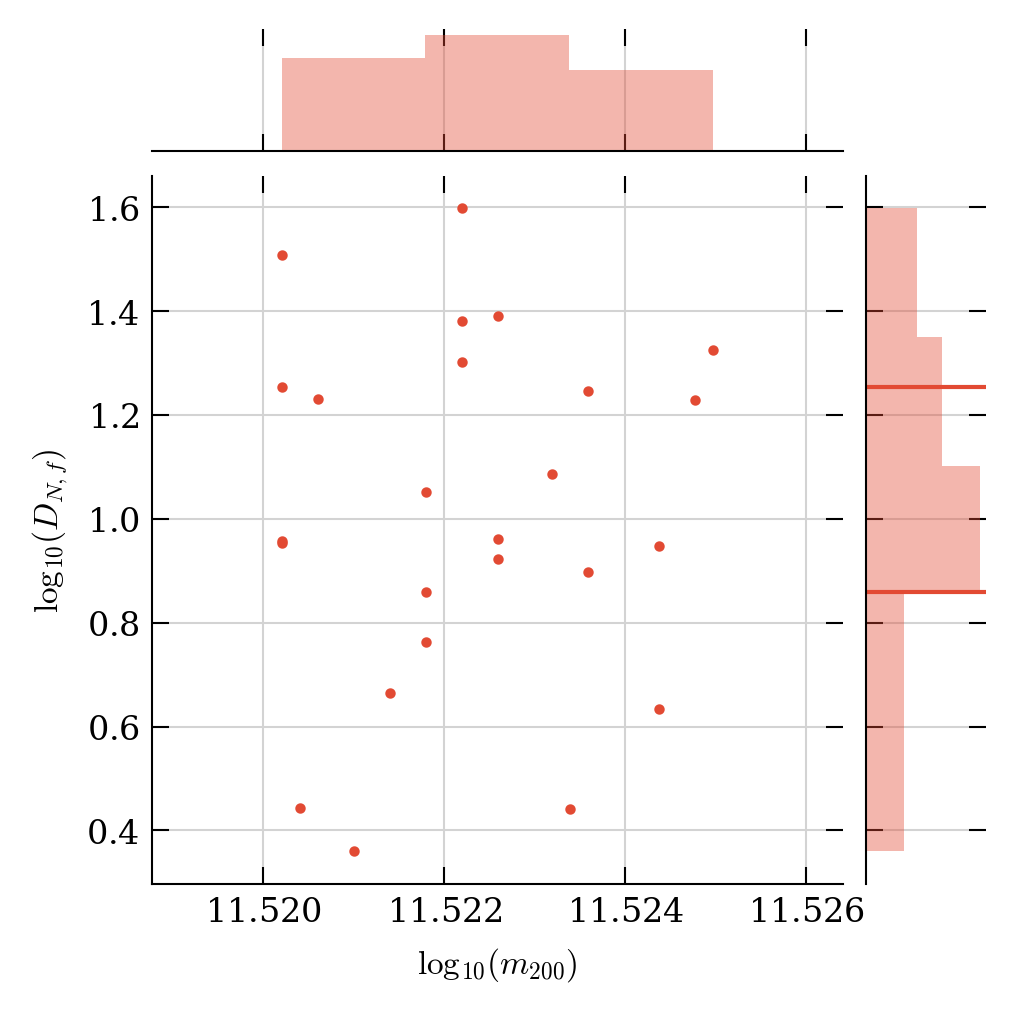

In [19]:
p = sns.jointplot(x="m", y="d", data=d, marker=".", stat_func=None, height=3.4)

plt.axhline(qs[0])
plt.axhline(qs[1])

p.set_axis_labels(r"$\log_{10}(m_{200})$", r"$\log_{10}(D_{N,f})$")

# if savefig:
#     p.savefig("./plots/dnf_%s_%03d.pdf" % (grav, snap))